这个文档用来画图制成movie

In [1]:
import sunpy
import sunpy.map
import numpy as np
from math import *
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sunpy.coordinates import frames
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from matplotlib.patches import ConnectionPatch
import os,cv2
from scipy.optimize import fmin
from scipy.ndimage import affine_transform
import shutil

c:\Users\19671\anaconda3\envs\sun\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
import cv2
import os

def images_to_video(image_folder, output_folder, video_name, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    output_path = os.path.join(output_folder, video_name)
    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
images_to_video('D:/Learning/PHD1st/magnetic reconnecion/data/CHASE_Ha_image1/',\
                'D:/Learning/PHD1st/magnetic reconnecion/data/','sub_chase_Ha1.avi',3)

FFT算会不会更快?

In [15]:
def neg_corrcoef(offset, A, B):
    # 计算插值后的子矩阵C
    C = affine_transform(B, np.array([[1, 0, offset[0]], [0, 1, offset[1]]]),
                        output_shape=A.shape, order=1)  # order=1 表示线性插值
    corr = np.corrcoef(A.flatten(), C.flatten())[0, 1]
    return -corr**2  # 我们最小化1 - corr^2来间接最大化corr

羲和号Ha的对齐画图像连成视频

In [11]:
path='D:/Learning/PHD1st/magnetic_reconnecion/data/IRIS/iris_l2_20240618_163141_3602506433_SJI_1400_t000.fits'
rsm=fits.open(path)
coord_HIS=SkyCoord(0*u.arcsec,0*u.arcsec,obstime=rsm[0].header['DATE_OBS'],observer='earth',frame=frames.Helioprojective)


__<font color=red size=5>尝试将IDL的数据存储然后用python读取出</font>__

In [6]:
import numpy as np

# 文件名
filename = 'C:/Users/19671/matrix_test.dat'

# 读取数据（假设数据类型是float32）
data = np.fromfile(filename, dtype=np.float32)
print(data)
m1=data.reshape((3,4,2))
print(m1)

[2.  2.  2.5 2.5 2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.
 4.  4.  4.  4.  4.  4. ]
[[[2.  2. ]
  [2.5 2.5]
  [2.  2. ]
  [2.  2. ]]

 [[3.  3. ]
  [3.  3. ]
  [3.  3. ]
  [3.  3. ]]

 [[4.  4. ]
  [4.  4. ]
  [4.  4. ]
  [4.  4. ]]]


In [7]:
import numpy as np

# 文件名
filename = 'C:/Users/19671/matrix_3d.dat'

# 读取数据（假设数据类型是float32）
data = np.fromfile(filename, dtype=np.float32)

# 重新塑形为原始的三维矩阵
m1 = data.reshape((990,778,801))
s1=m1[10,:,:]
print(s1.mean())

-25.872854


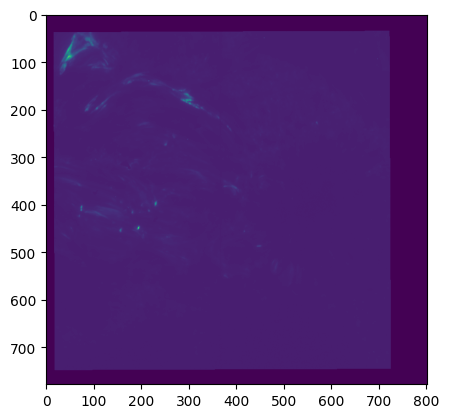

In [10]:
plt.imshow(s1)

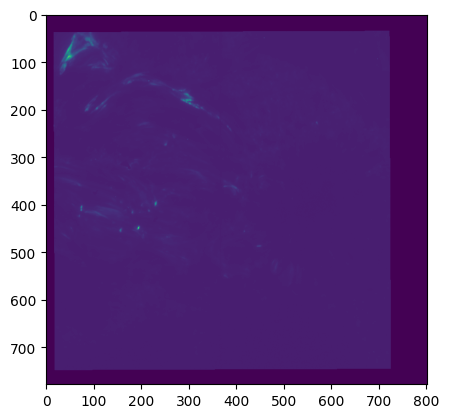

In [34]:
plt.imshow(s1)
plt.grid(False)

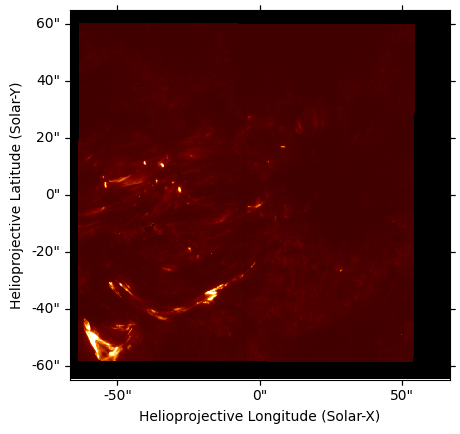

In [ ]:
data=s1
header=sunpy.map.make_fitswcs_header(data,coord_HIS,scale=[0.1667,0.1667]*u.arcsec/u.pixel)
header_map=sunpy.map.Map(data,header)
fig=plt.figure()
ax=fig.add_subplot(111,projection=header_map)
header_map.plot(axes=ax,cmap='afmhot',vmin=0.5*s1.min(),vmax=0.3*s1.max(),title=False)
ax.coords[0].grid(draw_grid=False)
ax.coords[1].grid(draw_grid=False)
'''
ax.set_xlabel(' ')
ax.set_ylabel(' ')
'''

In [ ]:
#25张图为羲和的一次观测，我先选第一张图的一部分A=data[500:1000,1200:1700]也就是目标的位置
# 之后每张图选取一个稍微大一点的范围B=data[400:1100,1100:1800]，进行对齐找到最佳偏移量，存储为offset_sum.npy
#该文件为25*2的矩阵，每一行第一个数对应data矩阵的第一个坐标，第二个数对应data矩阵的第二个坐标，但是在sunpy画图里是反过来的
path='D:/Learning/PHD1st/magnetic reconnecion/data/CHASE_Ha/'
name=os.listdir(path)
rsm0=fits.open(path+name[0])
data=rsm0[1].data[68,:,:]
A=data[500:1000,1200:1700]
coord_HIS=SkyCoord(0*u.arcsec,0*u.arcsec,obstime=rsm0[1].header['DATE_OBS'],observer='earth',frame=frames.Helioprojective)
#注意这个1200和500与上面矩阵坐标的差别
headercore = sunpy.map.make_fitswcs_header(A, coord_HIS,reference_pixel = [rsm0[1].header['CRPIX1']-1200, rsm0[1].header['CRPIX2']-500] * u.pixel,
                                    scale = [0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,telescope = 'CHASE', instrument = 'RSM')
hacore_map = sunpy.map.Map(A, headercore,autoalign=True)
hacore_map.plot(cmap = 'afmhot' , vmin = 0, vmax = 4 * data.mean())
plt.savefig('D:/Learning/PHD1st/magnetic reconnecion/data/CHASE_Ha_image1/'+name[0]+'.png')
plt.close()
offset_sum=np.zeros((25,2))
offset_sum[0,:]=500,1200
for i in range(24):
    rsm=fits.open(path+name[i+1])
    data=rsm[1].data[68,:,:]
    B=data[400:1100,1100:1800]
    x0, y0 = 100.0,100.0 
    best_offset = fmin(neg_corrcoef, np.array([x0, y0]), args=(A, B), disp=False, xtol=1e-6, ftol=1e-6)
    best_x, best_y = best_offset
    offset_sum[i+1,:]=[400+best_x,1100+best_y]
    C = affine_transform(B, np.array([[1, 0, best_x], [0, 1, best_y]]),
                        output_shape=A.shape, order=1)
    coord_HIS=SkyCoord(0*u.arcsec,0*u.arcsec,obstime=rsm[1].header['DATE_OBS'],observer='earth',frame=frames.Helioprojective)
    headercore = sunpy.map.make_fitswcs_header(C, coord_HIS,reference_pixel = [rsm[1].header['CRPIX1']-1100-best_y, rsm[1].header['CRPIX2']-400-best_x] * u.pixel,
                                        scale = [0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,telescope = 'CHASE', instrument = 'RSM')
    hacore_map = sunpy.map.Map(C, headercore,autoalign=True)
    hacore_map.plot(cmap = 'afmhot' , vmin = 0, vmax = 4 * data.mean())
    plt.savefig('D:/Learning/PHD1st/magnetic reconnecion/data/CHASE_Ha_image1/'+name[i+1]+'.png')
    plt.close()
np.save('offset_sum.npy',offset_sum)

In [6]:
import cv2
import os

def images_to_video(image_folder, output_folder, video_name, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".bmp")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    output_path = os.path.join(output_folder, video_name)
    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
images_to_video('D:/Learning/PHD1st/AIA/AIA335/','D:/Learning/PHD1st/magnetic_reconnecion/data','AIA335.avi',6)

In [15]:
print((path+name[0])[-19:-16])

211


In [18]:
path='D:/Learning/PHD1st/magnetic reconnecion/data/AIA/JSOC_20241030_000727/'
path2='D:/Learning/PHD1st/magnetic reconnecion/data/AIA/AIA'
name=os.listdir(path)
for i in range(len(name)):
    shutil.copy(path+name[i],path2+(path+name[i])[-19:-16]+'/')

In [4]:
from astropy.coordinates import SkyCoord
import astropy.units as u

import sunpy.map
from sunpy.data.sample import AIA_171_IMAGE  


In [9]:
aia171='D:/Learning/PHD1st/magnetic reconnecion/data/AIA/JSOC_20241030_000727/aia.lev1_euv_12s.2024-06-18T195010Z.171.image_lev1.fits'
amap=sunpy.map.Map(aia171)

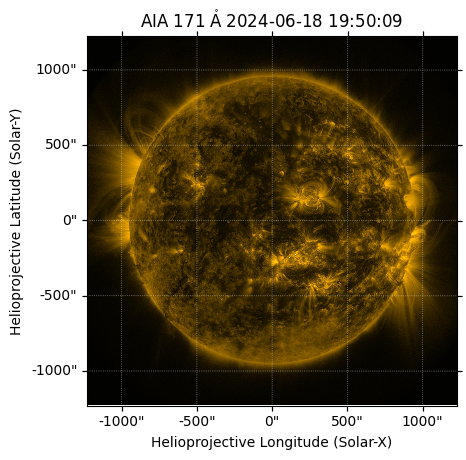

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(projection=amap)  
amap.plot()  


In [1]:
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import sunpy.map
from sunpy.coordinates import Helioprojective, propagate_with_solar_surface
from sunpy.data.sample import AIA_171_IMAGE

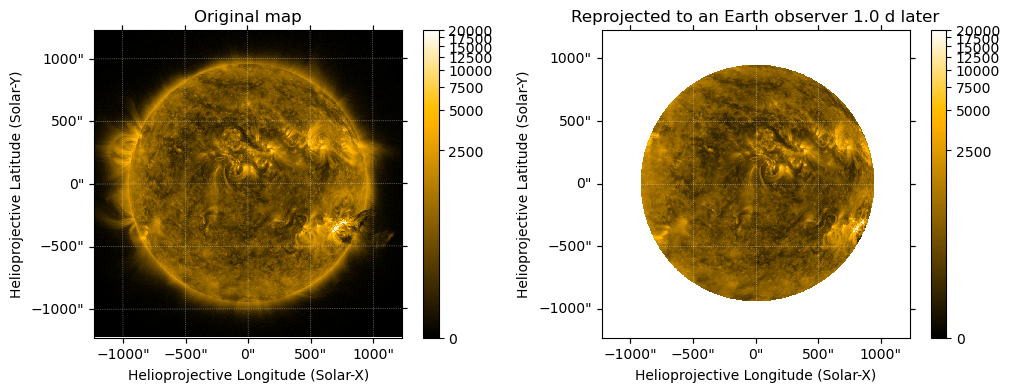

In [3]:
aiamap = sunpy.map.Map(AIA_171_IMAGE)
in_time = aiamap.date
out_time = in_time + 1*u.day
out_frame = Helioprojective(observer='earth', obstime=out_time,
                            rsun=aiamap.coordinate_frame.rsun)
out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
header = sunpy.map.make_fitswcs_header(aiamap.data.shape,
                                       out_center,
                                       scale=u.Quantity(aiamap.scale))
out_wcs = WCS(header)
with propagate_with_solar_surface():
    out_warp = aiamap.reproject_to(out_wcs)
    fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121, projection=aiamap)
aiamap.plot(axes=ax1, vmin=0, vmax=20000, title='Original map')
plt.colorbar()

ax2 = fig.add_subplot(122, projection=out_warp)
out_warp.plot(axes=ax2, vmin=0, vmax=20000,
              title=f"Reprojected to an Earth observer {(out_time - in_time).to('day')} later")
plt.colorbar()

plt.show()